In [1]:
import sys
sys.path.insert(0, '/net/proteome/home/nezar/local/devel/bioframe/')
sys.path.insert(0, '/net/proteome/home/nezar/local/devel/mirnymental/nezar/')
%matplotlib inline

In [2]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn.apionly as sns
import mirnylib.plotting
mpl.style.use('seaborn-poster')

import numpy as np
import pandas as pd
import bioframe
import bioframe.dask
import dask
import distributed
import cooler
from scipy.linalg import toeplitz
import cooler_expected_new as cooler_expected

from cooler.contrib.dask import daskify

In [3]:
from __future__ import division, print_function
from multiprocess import Pool
from functools import partial
from itertools import chain
import itertools
import argparse
import sys

from scipy.signal import fftconvolve
import numpy as np
import pandas as pd

import cooler
from cooler.contrib.dask import daskify
from cooler.tools import split, partition
import dask.dataframe as dd
import dask.array as da

where = np.flatnonzero
concat = chain.from_iterable


In [24]:
def lattice_pdist_frequencies(n, points):
    """
    Distribution of pairwise 1D distances among a collection of distinct
    integers ranging from 0 to n-1.

    Parameters
    ----------
    n : int
        Size of the lattice on which the integer points reside.
    points : sequence of int
        Arbitrary integers between 0 and n-1, inclusive, in any order but 
        with no duplicates.

    Returns
    -------
    h : 1D array of length n
        h[d] counts the number of integer pairs that are exactly d units apart

    Notes
    -----
    This is done using a convolution via FFT. Thanks to Peter de Rivaz; see
    <http://stackoverflow.com/questions/42423823/distribution-of-pairwise-
    distances-between-many-integers>.
    
    """
    if len(np.unique(points)) != len(points):
        raise ValueError("Integers must be distinct.")
    x = np.zeros(n); x[points] = 1
    return np.round(fftconvolve(x, x[::-1], mode='full')).astype(int)[-n:]


def count_bad_pixels_per_diag(n, bad_bins):
    """
    Efficiently count the number of bad pixels on each upper diagonal of a
    matrix assuming a sequence of bad bins forms a "grid" of invalid pixels.
    
    Each bad bin bifurcates into two a row and column of bad pixels, so an 
    upper bound on number of bad pixels per diagonal is 2*k, where k is the 
    number of bad bins. For a given diagonal, we need to subtract from this
    upper estimate the contribution from rows/columns reaching "out-of-bounds"
    and the contribution of the intersection points of bad rows with bad
    columns that get double counted.
    
    o : bad bin
    * : bad pixel
    x : intersection bad pixel
    $ : out of bounds bad pixel

         $    $     $
     *--------------------------+    
      *  *    *     *           |    
       * *    *     *           |    
        **    *     *           |    
         o****x*****x***********|$    
          *   *     *           |    
           *  *     *           |    
            * *     *           |    
             o******x***********|$    
              *     *           |    
               *    *           |    
                *   *           |    
                 *  *           |    
                  * *           |    
                   **           |    
                    o***********|$    
                     *          |    
                      *         |    
    
    Parameters
    ----------
    n : int
        total number of bins
    bad_bins : 1D array of int
        sorted array of bad bin indexes

    Returns
    -------
    dcount : 1D array of length n
        dcount[d] == number of bad pixels on diagonal d
    
    """
    k = len(bad_bins)
    dcount = np.zeros(n, dtype=int)

    # Store all intersection pixels in a separate array
    # ~O(n log n) with fft
    ixn = lattice_pdist_frequencies(n, bad_bins)
    dcount[0] = ixn[0]

    # Keep track of out-of-bounds pixels by squeezing left and right bounds
    # ~O(n)
    pl = 0
    pr = k
    for diag in range(1, n):
        if pl < k:
            while (bad_bins[pl] - diag) < 0:
                pl += 1
                if pl == k:
                    break
        if pr > 0:
            while (bad_bins[pr-1] + diag) >= n:
                pr -= 1
                if pr == 0:
                    break
        dcount[diag] = 2*k - ixn[diag] - pl - (k - pr)
    return dcount


def count_all_pixels_per_diag(n):
    """
    Total number of pixels on each upper diagonal of a square matrix.

    Parameters
    ----------
    n : int
        total number of bins (dimension of square matrix)

    Returns
    -------
    dcount : 1D array of length n
        dcount[d] == total number of pixels on diagonal d

    """
    return np.arange(n, 0, -1)



def make_diag_table(bad_mask, span1, span2):
    """
    Compute the total number of elements ``n_elem`` and the number of bad 
    elements ``n_bad`` per diagonal for a single contact area encompassing 
    ``span1`` and ``span2`` on the same genomic scaffold (cis matrix).

    Follows the same principle as the algorithm for finding contact areas for
    computing scalings.

    Parameters
    ----------
    bad_mask : 1D array of bool
        Mask of bad bins for the whole genomic scaffold containing the regions
        of interest.
    span1, span2 : pair of ints
        The bin spans (not genomic coordinates) of the two regions of interest.

    Returns
    -------
    diags : pandas.DataFrame
        Table indexed by 'diag' with columns ['n_elem', 'n_bad'].

    """
    def _make_diag_table(n_bins, bad_locs):
        diags = pd.DataFrame(index=pd.Series(np.arange(n_bins), name='diag'))
        diags['n_valid'] = (count_all_pixels_per_diag(n_bins) - 
                            count_bad_pixels_per_diag(n_bins, bad_locs))
        return diags
    
    if span1 == span2:
        lo, hi = span1
        diags = _make_diag_table(hi - lo, where(bad_mask[lo:hi]))
    else:
        lo1, hi1 = span1
        lo2, hi2 = span2
        if lo2 <= lo1:
            lo1, lo2 = lo2, lo1
            hi1, hi2 = hi2, hi1
        diags = (
            _make_diag_table(hi2 - lo1, where(bad_mask[lo1:hi2]))
                .subtract(_make_diag_table(lo2 - lo1, where(bad_mask[lo1:lo2])), 
                          fill_value=0)
                .subtract(_make_diag_table(hi2 - hi1, where(bad_mask[hi1:hi2])), 
                          fill_value=0)            
        )
        if hi1 < lo2:
            diags.add(_make_diag_table(lo2 - hi1, where(bad_mask[hi1:lo2])), 
                      fill_value=0)
        diags = diags[diags['n_elem'] > 0]
    return diags.astype(int)


def sum_diagonals(df, field):
    reduced = df.groupby('diag')[field].sum()
    reduced.name = field + '.sum'
    return reduced


def compute_expected(clr, regions, field='balanced', chunksize=1000000):
    pixels = daskify(clr.filename, 'pixels', chunksize=chunksize)
    pixels = cooler.annotate(pixels, clr.bins(), replace=False)
    pixels = pixels[pixels.chrom1 == pixels.chrom2]
    chroms = [region[0] for region in regions]
    cis_maps = {chrom: pixels[pixels.chrom1==chrom] for chrom in chroms}

    diag_tables = []
    data_sums = []

    for region in regions:
        if len(region) == 1:
            chrom, = region
            start1, end1 = 0, clr.chromsizes[chrom]
            start2, end2 = start1, end1
        elif len(region) == 3:
            chrom, start1, end1 = region
            start2, end2 = start1, end1
        elif len(region) == 5:
            chrom, start1, end1, start2, end2 = region
        else:
            raise ValueError("Regions must be sequences of length 1, 3 or 5")

        bins = clr.bins().fetch(chrom).reset_index(drop=True)
        bad_mask = np.array(bins['weight'].isnull())
        lo1, hi1 = clr.extent((chrom, start1, end1))
        lo2, hi2 = clr.extent((chrom, start2, end2))
        co = clr.offset(chrom)
        lo1 -= co
        lo2 -= co
        hi1 -= co
        hi2 -= co

        dt = make_diag_table(bad_mask, [lo1, hi1], [lo2, hi2])
        sel = bioframe.bg2slice_frame(
            cis_maps[chrom], 
            (chrom, start1, end1), 
            (chrom, start2, end2)
        ).copy()
        sel['diag'] = sel['bin2_id'] - sel['bin1_id']
        sel['balanced'] = sel['count'] * sel['weight1'] * sel['weight2']
        agg = sum_diagonals(sel, field)
        diag_tables.append(dt)
        data_sums.append(agg)

    # run dask scheduler
    if len(data_sums) and isinstance(data_sums[0], dd.Series):
        data_sums = dd.compute(*data_sums)

    # append to tables
    for dt, agg in zip(diag_tables, data_sums):
        dt[agg.name] = 0
        dt[agg.name] = dt[agg.name].add(agg, fill_value=0)
        dt.loc[:2, agg.name] = np.nan

    # merge and return
    dtable = pd.concat(diag_tables, 
                     keys=list(chroms),
                     names=['chrom'])
    dtable['balanced.avg'] = dtable['balanced.sum'] / dtable['n_valid']
    return dtable


def compute_trans_expected(clr, pixels, chromosomes):
    def n_total_trans_elements(clr, chromosomes):
        n = 0
        x = [clr.extent(chrom)[1] - clr.extent(chrom)[0] 
                 for chrom in chromosomes]
        for i in range(len(x)):
            for j in range(i + 1, len(x)):
                n += x[i] * x[j]
        return n

    def n_bad_trans_elements(clr, chromosomes):
        n = 0
        x = [np.sum(clr.bins()['weight']
                       .fetch(chrom)
                       .isnull()
                       .astype(int)
                       .values)
                 for chrom in chromosomes]
        for i in range(len(x)):
            for j in range(i + 1, len(x)):
                n += x[i] * x[j]
        return n

    pixels = cooler.annotate(pixels, clr.bins(), replace=False)
    pixels = pixels[
        (pixels.chrom1.isin(chromosomes)) &
        (pixels.chrom2.isin(chromosomes)) &
        (pixels.chrom1 != pixels.chrom2)
    ]
    pixels['balanced'] = pixels['count'] * pixels['weight1'] * pixels['weight2']
    ntot = n_total_trans_elements(clr, chromosomes)
    nbad = n_bad_trans_elements(clr, chromosomes)
    trans_area = ntot - nbad
    trans_sum = pixels['balanced'].sum().compute()
    return trans_sum, trans_area


In [20]:
cluster = distributed.LocalCluster(n_workers=8)
client = distributed.Client(cluster)
client

<Client: scheduler='tcp://127.0.0.1:33799' processes=8 cores=40>

In [21]:
binsize = 5000
longnames = {
    'U': 'UNTR',
    'T': 'TAM',
    'N': 'NIPBL'
}
clrs = {
    'U': cooler.Cooler(f'/net/levsha/share/nezar/TCCSpitz2015_distiller/output/coolers/library_group/UNTR.{binsize}.cool'),
    'T': cooler.Cooler(f'/net/levsha/share/nezar/TCCSpitz2015_distiller/output/coolers/library_group/TAM.{binsize}.cool'),
    'N': cooler.Cooler(f'/net/levsha/share/nezar/TCCSpitz2015_distiller/output/coolers/library_group/NIPBL.{binsize}.cool'),
}

In [22]:
chromsizes = cooler.util.fetch_chromsizes('mm9')[:'chr19']
chromosomes = list(chromsizes.index)
regions = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

In [25]:
expected = {}
for cond in ['U', 'T', 'N']:
    expected[cond] = compute_expected(clrs[cond], regions)
    expected[cond].to_csv('{}.{}.expected.txt'.format(longnames[cond], binsize))

In [26]:
expected['U']

n_valid  balanced.sum  balanced.avg
chrom diag                                      
chr1  0        37505           NaN           NaN
      1        36765           NaN           NaN
      2        36719           NaN           NaN
      3        36712    347.257539      0.009459
      4        36706    277.175077      0.007551
      5        36696    227.211984      0.006192
      6        36692    193.572324      0.005276
      7        36682    166.844372      0.004548
      8        36682    147.194655      0.004013
      9        36670    133.408979      0.003638
      10       36668    124.061074      0.003383
      11       36664    110.899576      0.003025
      12       36664    103.791855      0.002831
      13       36659     93.872428      0.002561
      14       36649     88.404068      0.002412
      15       36652     84.594194      0.002308
      16       36645     79.354078      0.002165
      17       36638     76.443009      0.002086
      18       36642     69.458462      0.001896
      19       36638     69.667872      0.001902
      20       36628     66.086740      0.001804
      21       36624     61.828751      0.001688
      22       36620     60.540031      0.001653
      23       36617     57.862785      0.001580
      24       36617     58.010012      0.001584
      25       36610     52.665356      0.001439
      26       36615     53.062673      0.001449
      27       36605     51.765142      0.001414
      28       36600     48.867265      0.001335
      29       36596     48.526980      0.001326
...              ...           ...           ...
chr19 12239        0      0.000000           NaN
      12240        0      0.000000           NaN
      12241        0      0.000000           NaN
      12242        0      0.000000           NaN
      12243        0      0.000000           NaN
      12244        0      0.000000           NaN
      12245        0      0.000000           NaN
      12246        0      0.000000           NaN
      12247        0      0.000000           NaN
      12248        0      0.000000           NaN
      12249        0      0.000000           NaN
      12250        0      0.000000           NaN
      12251        0      0.000000           NaN
      12252        0      0.000000           NaN
      12253        0      0.000000           NaN
      12254        0      0.000000           NaN
      12255        0      0.000000           NaN
      12256        0      0.000000           NaN
      12257        0      0.000000           NaN
      12258        0      0.000000           NaN
      12259        0      0.000000           NaN
      12260        0      0.000000           NaN
      12261        0      0.000000           NaN
      12262        0      0.000000           NaN
      12263        0      0.000000           NaN
      12264        0      0.000000           NaN
      12265        0      0.000000           NaN
      12266        0      0.000000           NaN
      12267        0      0.000000           NaN
      12268        0      0.000000           NaN

[494476 rows x 3 columns]

NameError: name 'X' is not defined

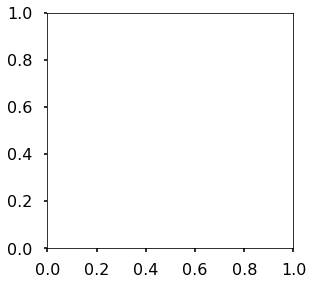

In [10]:
gs = GridSpec(nrows=2, ncols=3, height_ratios=[20, 1])

for cond in ['U', 'T', 'N']:
    plt.figure(figsize=(15, 5))
    
    exp = expected[cond]
    O = clrs[cond].matrix().fetch('chr19')
    e = exp.loc['chr19']['balanced.avg']
    E = toeplitz(e.values)
    
    ax = plt.subplot(gs[0])
    img = ax.matshow(np.log10(X), cmap='fall', vmin=-4, vmax=-1.5)
    cax = plt.subplot(gs[3])
    plt.colorbar(img, cax=cax, orientation='horizontal')

    ax = plt.subplot(gs[1])
    img = ax.matshow(np.log10(E), cmap='fall', vmin=-4, vmax=-1.5)
    cax = plt.subplot(gs[4])
    plt.colorbar(img, cax=cax, orientation='horizontal')

    ax = plt.subplot(gs[2])
    img = ax.matshow(np.log10(O / E), cmap='coolwarm', vmin=-1, vmax=1)
    cax = plt.subplot(gs[5])
    plt.colorbar(img, cax=cax, orientation='horizontal')